In [1]:
!pip install -U pip
!pip uninstall -y tensorflow keras tf-keras
!pip install -U tensorflow


Found existing installation: tensorflow 2.20.0
Uninstalling tensorflow-2.20.0:
  Successfully uninstalled tensorflow-2.20.0
Found existing installation: keras 3.12.0
Uninstalling keras-3.12.0:
  Successfully uninstalled keras-3.12.0
  Using cached tensorflow-2.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.5 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
Using cached tensorflow-2.20.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (620.4 MB)
Using cached keras-3.12.0-py3-none-any.whl (1.5 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [tensorflow]2 [tensorflow]


In [2]:
import tensorflow as tf
tf.__version__

2025-12-17 19:46:34.447958: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-17 19:46:34.489240: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-17 19:46:35.943399: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


'2.20.0'

In [3]:
import os, glob, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from scipy.signal import butter, filtfilt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

PARAMS = {
    "DATA_DIR": "Dataset",
    "FS": 128,
    "PRE_S": 0.25,
    "POST_S": 0.45,

    "BP_LOW": 0.5,
    "BP_HIGH": 40.0,
    "BP_ORDER": 4,

    # record-level split
    "TEST_FRAC": 0.20,   # kayıtların %20'si test
    "VAL_FRAC": 0.10,    # kayıtların %10'u val (train kalanından)

    "RANDOM_STATE": 42,

    # training
    "LR": 1e-3,
    "BATCH": 64,
    "EPOCHS": 40,

    # model
    "C1_F": 32, "C1_K": 7,
    "C2_F": 64, "C2_K": 5,
    "C3_F": 128,"C3_K": 3,
    "DROP_SIG": 0.30,
    "RR_DENSE": 16,
    "DROP_RR": 0.20,
    "FUSE_DENSE": 64,
    "DROP_FUSE": 0.30,

    "NOTES": "record-level benchmark"
}

print("TF:", tf.__version__)


TF: 2.20.0


In [4]:
def bandpass(x, fs):
    low, high, order = PARAMS["BP_LOW"], PARAMS["BP_HIGH"], PARAMS["BP_ORDER"]
    ny = 0.5 * fs
    b, a = butter(order, [low/ny, high/ny], btype="band")
    return filtfilt(b, a, x)

def pick_cols(ekg, ann):
    ekg.columns = [c.strip() for c in ekg.columns]
    ann.columns = [c.strip() for c in ann.columns]

    # ann: symbol
    sym_col = None
    for c in ann.columns:
        if c.lower() in {"symbol","annotation","label"}:
            sym_col = c; break
    if sym_col is None:
        sym_col = ann.columns[-1]

    # ann: index
    idx_col = None
    for c in ann.columns:
        if c == sym_col: 
            continue
        if ("sample" in c.lower()) or ("index" in c.lower()) or ("point" in c.lower()) or ("unnamed" in c.lower()):
            idx_col = c; break
    if idx_col is None:
        idx_col = [c for c in ann.columns if c != sym_col][0]

    ann2 = ann[[idx_col, sym_col]].rename(columns={idx_col:"sample_index", sym_col:"symbol"})
    ann2["sample_index"] = ann2["sample_index"].astype(int)
    ann2["symbol"] = ann2["symbol"].astype(str)

    # lead cols
    lead_cols = [c for c in ekg.columns if c.lower() in {"ecg1","ecg2","lead1","lead2"}]
    if len(lead_cols) < 2:
        candidates = [c for c in ekg.columns if not c.lower().startswith("unnamed")]
        num_candidates = [c for c in candidates if pd.api.types.is_numeric_dtype(ekg[c])]
        lead_cols = num_candidates[:2]
    lead_cols = lead_cols[:2]
    return ann2, lead_cols

def make_windows(ekg_df, ann2, lead_cols):
    fs = PARAMS["FS"]
    pre_s, post_s = PARAMS["PRE_S"], PARAMS["POST_S"]
    sig = ekg_df[lead_cols].values.astype(np.float32)

    sig_f = np.zeros_like(sig)
    for ch in range(sig.shape[1]):
        sig_f[:, ch] = bandpass(sig[:, ch], fs=fs)

    a = ann2.sort_values("sample_index")
    pre  = int(round(pre_s * fs))
    post = int(round(post_s * fs))
    L = pre + post + 1

    idx = a["sample_index"].values

    rr_prev = np.diff(idx, prepend=idx[0]).astype(np.float32) / fs
    rr_next = np.diff(idx, append=idx[-1]).astype(np.float32) / fs
    rr_ratio = np.divide(rr_prev, rr_next, out=np.ones_like(rr_prev), where=rr_next!=0)

    X, R, sym = [], [], []
    for i, sidx in enumerate(idx):
        start = sidx - pre
        end   = sidx + post
        if start < 0 or end >= len(sig_f):
            continue
        X.append(sig_f[start:end+1, :])
        R.append([rr_prev[i], rr_next[i], rr_ratio[i]])
        sym.append(a.iloc[i]["symbol"])

    X = np.stack(X).astype(np.float32)
    R = np.array(R, dtype=np.float32)
    sym = np.array(sym)
    return X, R, sym, L

def make_features(X, R, add_stats=True):
    n, L, C = X.shape
    flat = X.reshape(n, L*C)
    feats = [flat, R]
    if add_stats:
        mean = X.mean(axis=1)
        std  = X.std(axis=1)
        mn   = X.min(axis=1)
        mx   = X.max(axis=1)
        stats = np.concatenate([mean, std, mn, mx], axis=1)
        feats.append(stats)
    return np.concatenate(feats, axis=1).astype(np.float32)

# AAMI N/S/V/Q mapping (tüm dataset için stabil)
def to_aami4(symbol: str) -> str:
    s = str(symbol)
    if s in {"N"}: return "N"
    if s in {"S","A","a","J"}: return "S"
    if s in {"V","E"}: return "V"
    # Q: noise/unknown + F'yi de Q'ya katıyoruz (F azsa split sorun çıkarmasın)
    if s in {"~","|","F"}: return "Q"
    return "Q"

AAMI_CLASSES = ["N","S","V","Q"]
AAMI_TO_ID = {c:i for i,c in enumerate(AAMI_CLASSES)}


In [5]:
def record_paths(data_dir, rid):
    ekg_path = os.path.join(data_dir, f"{rid}_ekg.csv")
    ann_path = os.path.join(data_dir, f"{rid}_annotations.csv")
    return ekg_path, ann_path

records = list(range(800, 895))

X_all, R_all, y_all, g_all = [], [], [], []
L_ref = None
loaded = 0

for rid in records:
    ekg_path, ann_path = record_paths(PARAMS["DATA_DIR"], rid)
    if not (os.path.exists(ekg_path) and os.path.exists(ann_path)):
        print("SKIP missing:", rid)
        continue

    ekg = pd.read_csv(ekg_path)
    ann = pd.read_csv(ann_path)

    ann2, lead_cols = pick_cols(ekg, ann)
    X, R, sym, L = make_windows(ekg, ann2, lead_cols)

    # L sabit olmalı (FS, PRE, POST sabitse)
    if L_ref is None:
        L_ref = L
    else:
        if L != L_ref:
            print("WARN L mismatch at", rid, "L:", L, "ref:", L_ref, "-> skipping")
            continue

    y_aami = np.array([to_aami4(s) for s in sym])
    y = np.array([AAMI_TO_ID[c] for c in y_aami], dtype=np.int32)

    X_all.append(X); R_all.append(R); y_all.append(y)
    g_all.append(np.full((len(y),), rid, dtype=np.int32))

    loaded += 1
    if loaded % 10 == 0:
        print("loaded records:", loaded)

X_all = np.concatenate(X_all, axis=0)
R_all = np.concatenate(R_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
g_all = np.concatenate(g_all, axis=0)

print("TOTAL X:", X_all.shape, "R:", R_all.shape, "y:", y_all.shape)
print("Unique groups:", len(np.unique(g_all)))
print("AAMI counts:", pd.Series(y_all).value_counts().sort_index())


loaded records: 10
SKIP missing: 813
SKIP missing: 814
SKIP missing: 815
SKIP missing: 816
SKIP missing: 817
SKIP missing: 818
SKIP missing: 819
loaded records: 20
SKIP missing: 830
SKIP missing: 831
SKIP missing: 832
SKIP missing: 833
SKIP missing: 834
SKIP missing: 835
SKIP missing: 836
SKIP missing: 837
SKIP missing: 838
SKIP missing: 839
loaded records: 30
loaded records: 40
loaded records: 50
loaded records: 60
loaded records: 70
TOTAL X: (187802, 91, 2) R: (187802, 3) y: (187802,)
Unique groups: 78
AAMI counts: 0    162270
1     12195
2      9941
3      3396
Name: count, dtype: int64


In [6]:
# X_all: (N, L, 2), R_all: (N,3)
finite_X = np.isfinite(X_all).all(axis=(1,2))
finite_R = np.isfinite(R_all).all(axis=1)
keep = finite_X & finite_R

print("Bad windows:", int((~keep).sum()), " / ", len(keep))
X_all = X_all[keep]
R_all = R_all[keep]
y_all = y_all[keep]
g_all = g_all[keep]

print("After clean:", X_all.shape, R_all.shape, y_all.shape)


Bad windows: 2462  /  187802
After clean: (185340, 91, 2) (185340, 3) (185340,)


In [7]:
rs = PARAMS["RANDOM_STATE"]

gss1 = GroupShuffleSplit(n_splits=1, test_size=PARAMS["TEST_FRAC"], random_state=rs)
train_idx, test_idx = next(gss1.split(X_all, y_all, groups=g_all))

X_tr, R_tr, y_tr, g_tr = X_all[train_idx], R_all[train_idx], y_all[train_idx], g_all[train_idx]
X_te, R_te, y_te, g_te = X_all[test_idx],  R_all[test_idx],  y_all[test_idx],  g_all[test_idx]

# val: train içinden kayıt bazlı
gss2 = GroupShuffleSplit(n_splits=1, test_size=PARAMS["VAL_FRAC"], random_state=rs)
tr2_idx, va_idx = next(gss2.split(X_tr, y_tr, groups=g_tr))

X_train, R_train, y_train, g_train = X_tr[tr2_idx], R_tr[tr2_idx], y_tr[tr2_idx], g_tr[tr2_idx]
X_val,   R_val,   y_val,   g_val   = X_tr[va_idx],  R_tr[va_idx],  y_tr[va_idx],  g_tr[va_idx]
X_test,  R_test,  y_test,  g_test  = X_te,          R_te,          y_te,          g_te

print("Train groups:", len(np.unique(g_train)), "Val groups:", len(np.unique(g_val)), "Test groups:", len(np.unique(g_test)))
print("Train counts:", pd.Series(y_train).value_counts().sort_index())
print("Val counts  :", pd.Series(y_val).value_counts().sort_index())
print("Test counts :", pd.Series(y_test).value_counts().sort_index())


Train groups: 54 Val groups: 7 Test groups: 16
Train counts: 0    110323
1      7875
2      6054
3      2199
Name: count, dtype: int64
Val counts  : 0    16149
1      636
2      822
3      156
Name: count, dtype: int64
Test counts : 0    34125
1     3667
2     2338
3      996
Name: count, dtype: int64


In [8]:
"""Xtr_f = make_features(X_train, R_train, add_stats=True)
Xte_f = make_features(X_test,  R_test,  add_stats=True)

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_f)
Xte_s = scaler.transform(Xte_f)

logreg = LogisticRegression(
    solver="saga",
    max_iter=8000,
    class_weight="balanced",
    multi_class="multinomial"
)
logreg.fit(Xtr_s, y_train)
y_pred = logreg.predict(Xte_s)

print("== LogReg multinomial ==")
print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))
macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
print("Macro-F1:", macro_f1)
"""

'Xtr_f = make_features(X_train, R_train, add_stats=True)\nXte_f = make_features(X_test,  R_test,  add_stats=True)\n\nscaler = StandardScaler()\nXtr_s = scaler.fit_transform(Xtr_f)\nXte_s = scaler.transform(Xte_f)\n\nlogreg = LogisticRegression(\n    solver="saga",\n    max_iter=8000,\n    class_weight="balanced",\n    multi_class="multinomial"\n)\nlogreg.fit(Xtr_s, y_train)\ny_pred = logreg.predict(Xte_s)\n\nprint("== LogReg multinomial ==")\nprint(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))\nmacro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)\nprint("Macro-F1:", macro_f1)\n'

In [9]:
"""
Xtr_f = make_features(X_train, R_train, add_stats=True)
Xte_f = make_features(X_test,  R_test,  add_stats=True)

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_f)
Xte_s = scaler.transform(Xte_f)

logreg = LogisticRegression(
    solver="lbfgs",
    max_iter=300,
    class_weight="balanced",
    multi_class="multinomial"
)


logreg.fit(Xtr_s, y_train)
y_pred = logreg.predict(Xte_s)

print("== LogReg multinomial ==")
print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))
macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
print("Macro-F1:", macro_f1)
"""

'\nXtr_f = make_features(X_train, R_train, add_stats=True)\nXte_f = make_features(X_test,  R_test,  add_stats=True)\n\nscaler = StandardScaler()\nXtr_s = scaler.fit_transform(Xtr_f)\nXte_s = scaler.transform(Xte_f)\n\nlogreg = LogisticRegression(\n    solver="lbfgs",\n    max_iter=300,\n    class_weight="balanced",\n    multi_class="multinomial"\n)\n\n\nlogreg.fit(Xtr_s, y_train)\ny_pred = logreg.predict(Xte_s)\n\nprint("== LogReg multinomial ==")\nprint(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))\nmacro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)\nprint("Macro-F1:", macro_f1)\n'

In [10]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score

Xtr_f = make_features(X_train, R_train, add_stats=True)
Xte_f = make_features(X_test,  R_test,  add_stats=True)

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_f)
Xte_s = scaler.transform(Xte_f)

sgd_logreg = SGDClassifier(
    loss="log_loss",              # logistic regression
    penalty="l2",
    alpha=1e-4,                   # reg strength (tune edilebilir)
    max_iter=50,                  # hızlı
    tol=1e-3,
    class_weight="balanced",
    early_stopping=True,
    validation_fraction=0.1,
    n_jobs=-1,
    random_state=PARAMS["RANDOM_STATE"]
)

sgd_logreg.fit(Xtr_s, y_train)
y_pred = sgd_logreg.predict(Xte_s)

print("== SGD(LogReg) balanced ==")
print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro", zero_division=0))


== SGD(LogReg) balanced ==
              precision    recall  f1-score   support

           N     0.9596    0.8628    0.9086     34125
           S     0.3256    0.5086    0.3970      3667
           V     0.4720    0.6121    0.5330      2338
           Q     0.3828    0.6476    0.4812       996

    accuracy                         0.8117     41126
   macro avg     0.5350    0.6578    0.5799     41126
weighted avg     0.8614    0.8117    0.8313     41126

Macro-F1: 0.5799409755782665


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Label smoothing ekşeme false positive azalmatk için deniyorum.
def build_cnn_rr(input_len, n_channels=2, n_classes=4):
    x_in = keras.Input(shape=(input_len, n_channels), name="signal")

    x = layers.Conv1D(PARAMS["C1_F"], PARAMS["C1_K"], padding="same", activation="relu")(x_in)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(PARAMS["C2_F"], PARAMS["C2_K"], padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool1D(2)(x)

    x = layers.Conv1D(PARAMS["C3_F"], PARAMS["C3_K"], padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(PARAMS["DROP_SIG"])(x)

    rr_in = keras.Input(shape=(3,), name="rr")
    r = layers.Dense(PARAMS["RR_DENSE"], activation="relu")(rr_in)
    r = layers.Dropout(PARAMS["DROP_RR"])(r)

    h = layers.Concatenate()([x, r])
    h = layers.Dense(PARAMS["FUSE_DENSE"], activation="relu")(h)
    h = layers.Dropout(PARAMS["DROP_FUSE"])(h)

    out = layers.Dense(n_classes, activation="softmax")(h)

    model = keras.Model(inputs=[x_in, rr_in], outputs=out)

    LS = 0.01
    loss_fn = tf.keras.losses.CategoricalCrossentropy(label_smoothing=LS)

    model.compile(
    optimizer=tf.keras.optimizers.Adam(PARAMS["LR"]),
    loss=loss_fn,
    metrics=[tf.keras.metrics.CategoricalAccuracy(name="acc")]
    )

    return model

model = build_cnn_rr(input_len=L_ref, n_channels=2, n_classes=len(AAMI_CLASSES))
model.summary()


2025-12-17 19:46:52.759816: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ signal (InputLayer) │ (None, 91, 2)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 91, 32)    │        480 │ signal[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 91, 32)    │        128 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 45, 32)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 45, 64)    │     10,304 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 45, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 22, 64)    │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 22, 128)   │     24,704 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 22, 128)   │        512 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rr (InputLayer)     │ (None, 3)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 16)        │         64 │ rr[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 144)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      9,280 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4)         │        260 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,988 (179.64 KB)

 Trainable params: 45,540 (177.89 KB)

 Non-trainable params: 448 (1.75 KB)

In [12]:
import os, random
# fit proba ve fitten önce one hot verdim
from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(y_train)
cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
# class_weight hesapladıktan sonra:

class_weight = {int(c): float(w) for c,w in zip(classes, cw)}
print("class_weight:", class_weight)

CAP = 4.0
class_weight = {k: min(v, CAP) for k,v in class_weight.items()}
print("capped class_weight:", class_weight)

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", mode="min", patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", mode="min", patience=3, factor=0.5, min_lr=1e-5),
]

def zscore_per_window(X):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + 1e-6
    return (X - mu) / sd

X_train_n = zscore_per_window(X_train)
X_val_n   = zscore_per_window(X_val)
X_test_n  = zscore_per_window(X_test)

n_classes = len(AAMI_CLASSES)
y_train_oh = tf.one_hot(y_train, depth=n_classes)
y_val_oh   = tf.one_hot(y_val,   depth=n_classes)

# y_train / y_val hazır olmalı + class_weight dict hazır olmalı

sw_train = np.array([class_weight[int(c)] for c in y_train], dtype="float32")
sw_val   = np.array([class_weight[int(c)] for c in y_val],   dtype="float32")

print("sw_train stats:", sw_train.min(), sw_train.max(), sw_train.mean())
print("sw_val   stats:", sw_val.min(),   sw_val.max(),   sw_val.mean())


hist = model.fit(
    {"signal": X_train_n, "rr": R_train}, y_train_oh,
    sample_weight=sw_train,
    validation_data=({"signal": X_val_n, "rr": R_val}, y_val_oh, sw_val),
    epochs=PARAMS["EPOCHS"], batch_size=PARAMS["BATCH"],
    callbacks=callbacks,
    verbose=1
)


proba_val  = model.predict({"signal": X_val_n,  "rr": R_val})
proba_test = model.predict({"signal": X_test_n, "rr": R_test})

proba = proba_test
y_pred = np.argmax(proba, axis=1)


print("== CNN+RR ==")
print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))
macro_f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)
print("Macro-F1:", macro_f1)


class_weight: {0: 0.28654722949883527, 1: 4.014317460317461, 2: 5.221795507102742, 3: 14.375966348340155}
capped class_weight: {0: 0.28654722949883527, 1: 4.0, 2: 4.0, 3: 4.0}
sw_train stats: 0.28654724 4.0 0.760174
sw_val   stats: 0.28654724 4.0 0.6239629
Epoch 1/40
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - acc: 0.8555 - loss: 0.3598 - val_acc: 0.7876 - val_loss: 0.3588 - learning_rate: 0.0010
Epoch 2/40
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - acc: 0.9210 - loss: 0.2401 - val_acc: 0.8381 - val_loss: 0.3144 - learning_rate: 0.0010
Epoch 3/40
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.9276 - loss: 0.2141 - val_acc: 0.8222 - val_loss: 0.3066 - learning_rate: 0.0010
Epoch 4/40
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.9321 - loss: 0.1981 - val_acc: 0.7869 - val_loss: 0.3110 - learning_rate: 0.0010
Epoch 5/40
1976/1976 ━━━━━━━━━━━━━━━━━━━━ 27s 14ms/step - acc: 0.9338 - loss: 0.1890 - val_acc: 0.8074 - val_loss: 0.3131 - learning_rate: 0.0010
Epoch 6/40
19

In [13]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, precision_recall_fscore_support

Q_ID = AAMI_CLASSES.index("Q")

def apply_q_threshold_demote(proba, thr, q_id=Q_ID):
    # argmax pred
    pred = np.argmax(proba, axis=1)
    pQ = proba[:, q_id]

    # 2. en büyük sınıf (argmax dışındaki)
    top2 = np.argsort(proba, axis=1)[:, -2]

    # Eğer model Q dedi ama Q olasılığı thr altındaysa -> 2. sınıfa düşür
    mask = (pred == q_id) & (pQ < thr)
    pred2 = pred.copy()
    pred2[mask] = top2[mask]
    return pred2

def eval_for_thr(proba, y_true, thr):
    y_pred = apply_q_threshold_demote(proba, thr)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=[Q_ID], average=None, zero_division=0
    )
    return macro, pr[0], rc[0], f1[0]

ths = np.linspace(0.10, 0.95, 18)

rows = []
for thr in ths:
    macro, p, r, f1q = eval_for_thr(proba_val, y_val, thr)   # <-- VAL'de seç
    rows.append((thr, macro, p, r, f1q))

rows.sort(key=lambda x: x[1], reverse=True)
print("Top 8 (VAL) by Macro-F1:")
for thr, macro, p, r, f1q in rows[:8]:
    print(f"thr={thr:.2f} | Macro-F1={macro:.4f} | Q: P={p:.3f} R={r:.3f} F1={f1q:.3f}")

best_thr = rows[0][0]
print("\nBEST thr (VAL):", best_thr)

# Şimdi TEST'te raporla
y_pred_test = apply_q_threshold_demote(proba_test, best_thr)  # <-- proba_test / y_test
print(classification_report(y_test, y_pred_test, target_names=AAMI_CLASSES, digits=4, zero_division=0))
print("Macro-F1 (TEST):", f1_score(y_test, y_pred_test, average="macro", zero_division=0))


Top 8 (VAL) by Macro-F1:
thr=0.70 | Macro-F1=0.6918 | Q: P=0.889 R=0.821 F1=0.853
thr=0.75 | Macro-F1=0.6902 | Q: P=0.918 R=0.788 F1=0.848
thr=0.65 | Macro-F1=0.6871 | Q: P=0.848 R=0.821 F1=0.834
thr=0.80 | Macro-F1=0.6850 | Q: P=0.935 R=0.744 F1=0.829
thr=0.60 | Macro-F1=0.6836 | Q: P=0.807 R=0.833 F1=0.820
thr=0.55 | Macro-F1=0.6811 | Q: P=0.776 R=0.846 F1=0.810
thr=0.50 | Macro-F1=0.6808 | Q: P=0.749 R=0.878 F1=0.808
thr=0.85 | Macro-F1=0.6764 | Q: P=0.947 R=0.686 F1=0.796

BEST thr (VAL): 0.7
              precision    recall  f1-score   support

           N     0.9822    0.9081    0.9437     34125
           S     0.5615    0.8083    0.6626      3667
           V     0.5464    0.7712    0.6396      2338
           Q     0.9016    0.9016    0.9016       996

    accuracy                         0.8913     41126
   macro avg     0.7479    0.8473    0.7869     41126
weighted avg     0.9179    0.8913    0.9003     41126

Macro-F1 (TEST): 0.7868826840589914


In [14]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_recall_fscore_support

# sınıf id'lerini bul
S_ID = AAMI_CLASSES.index("S")
V_ID = AAMI_CLASSES.index("V")
Q_ID = AAMI_CLASSES.index("Q")

def apply_thresholds_demote(proba, thr_q=0.40, thr_s=None, thr_v=None, order=("Q","V","S")):
    pred = np.argmax(proba, axis=1)
    top2 = np.argsort(proba, axis=1)[:, -2]

    thr_map = {"S": thr_s, "V": thr_v, "Q": thr_q}
    id_map  = {"S": S_ID,  "V": V_ID,  "Q": Q_ID}

    pred2 = pred.copy()
    for cls in order:
        thr = thr_map[cls]
        if thr is None:
            continue
        cid = id_map[cls]
        p = proba[:, cid]
        mask = (pred2 == cid) & (p < thr)   # cls dedi ama güveni düşükse -> 2. sınıfa düşür
        pred2[mask] = top2[mask]
    return pred2

def class_recall(y_true, y_pred, class_id):
    pr, rc, f1, sup = precision_recall_fscore_support(
        y_true, y_pred, labels=[class_id], average=None, zero_division=0
    )
    return float(rc[0])

# grid (istersen dar/geniş yaparız)
ths = [0.30, 0.40, 0.50, 0.60, 0.70]

best = None
rows = []
for thr_s in ths:
    for thr_v in ths:
        ypv = apply_thresholds_demote(proba_val, thr_q=0.40, thr_s=thr_s, thr_v=thr_v, order=("Q","V","S"))
        macro = f1_score(y_val, ypv, average="macro", zero_division=0)
        rS = class_recall(y_val, ypv, S_ID)
        rV = class_recall(y_val, ypv, V_ID)
        rQ = class_recall(y_val, ypv, Q_ID)
        rows.append((macro, thr_s, thr_v, rS, rV, rQ))

rows.sort(reverse=True, key=lambda x: x[0])

print("Top 10 (VAL) by Macro-F1 (Q fixed @0.40):")
for macro, thr_s, thr_v, rS, rV, rQ in rows[:10]:
    print(f"Macro-F1={macro:.4f} | thr_S={thr_s:.2f} thr_V={thr_v:.2f} | Recalls: S={rS:.3f} V={rV:.3f} Q={rQ:.3f}")

best_macro, best_thr_s, best_thr_v, best_rS, best_rV, best_rQ = rows[0]
print("\nBEST (VAL):", best_macro, "thr_S", best_thr_s, "thr_V", best_thr_v)

# TEST raporu
ypt = apply_thresholds_demote(proba_test, thr_q=0.40, thr_s=best_thr_s, thr_v=best_thr_v, order=("Q","V","S"))
print("\n=== TEST report (Q fixed @0.40 + best S/V thresholds) ===")
print(classification_report(y_test, ypt, target_names=AAMI_CLASSES, digits=4, zero_division=0))
print("Macro-F1 (TEST):", f1_score(y_test, ypt, average="macro", zero_division=0))


Top 10 (VAL) by Macro-F1 (Q fixed @0.40):
Macro-F1=0.6828 | thr_S=0.30 thr_V=0.60 | Recalls: S=0.731 V=0.918 Q=0.910
Macro-F1=0.6819 | thr_S=0.30 thr_V=0.50 | Recalls: S=0.714 V=0.938 Q=0.910
Macro-F1=0.6792 | thr_S=0.30 thr_V=0.70 | Recalls: S=0.745 V=0.884 Q=0.917
Macro-F1=0.6767 | thr_S=0.40 thr_V=0.60 | Recalls: S=0.722 V=0.918 Q=0.910
Macro-F1=0.6764 | thr_S=0.30 thr_V=0.40 | Recalls: S=0.697 V=0.950 Q=0.910
Macro-F1=0.6758 | thr_S=0.40 thr_V=0.50 | Recalls: S=0.704 V=0.938 Q=0.910
Macro-F1=0.6752 | thr_S=0.50 thr_V=0.60 | Recalls: S=0.709 V=0.925 Q=0.936
Macro-F1=0.6749 | thr_S=0.50 thr_V=0.50 | Recalls: S=0.692 V=0.944 Q=0.936
Macro-F1=0.6731 | thr_S=0.40 thr_V=0.70 | Recalls: S=0.736 V=0.884 Q=0.917
Macro-F1=0.6721 | thr_S=0.30 thr_V=0.30 | Recalls: S=0.692 V=0.950 Q=0.904

BEST (VAL): 0.6827807957838514 thr_S 0.3 thr_V 0.6

=== TEST report (Q fixed @0.40 + best S/V thresholds) ===
              precision    recall  f1-score   support

           N     0.9859    0.9228    0.953

In [15]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score
import numpy as np

# Feature
Xtr_f = make_features(X_train, R_train, add_stats=True)
Xva_f = make_features(X_val,   R_val,   add_stats=True)
Xte_f = make_features(X_test,  R_test,  add_stats=True)

scaler = StandardScaler()
Xtr_s = scaler.fit_transform(Xtr_f)
Xva_s = scaler.transform(Xva_f)
Xte_s = scaler.transform(Xte_f)

# 1) Train LinearSVC on TRAIN
svm = LinearSVC(class_weight="balanced", random_state=PARAMS["RANDOM_STATE"])
svm.fit(Xtr_s, y_train)

# 2) Calibrate on VAL (prefit)
cal = CalibratedClassifierCV(svm, method="sigmoid", cv="prefit")
cal.fit(Xva_s, y_val)

# Predict proba on TEST
proba = cal.predict_proba(Xte_s)  # shape (n,4)
y_pred = np.argmax(proba, axis=1)

print("== Calibrated LinearSVC (sigmoid, prefit) ==")
print(classification_report(y_test, y_pred, target_names=AAMI_CLASSES, digits=4, zero_division=0))
print("Macro-F1:", f1_score(y_test, y_pred, average="macro", zero_division=0))


/usr/local/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


== Calibrated LinearSVC (sigmoid, prefit) ==
              precision    recall  f1-score   support

           N     0.8857    0.9941    0.9368     34125
           S     0.7035    0.1721    0.2765      3667
           V     0.9117    0.5740    0.7045      2338
           Q     0.8587    0.3906    0.5369       996

    accuracy                         0.8823     41126
   macro avg     0.8399    0.5327    0.6137     41126
weighted avg     0.8702    0.8823    0.8550     41126

Macro-F1: 0.6136619106764966


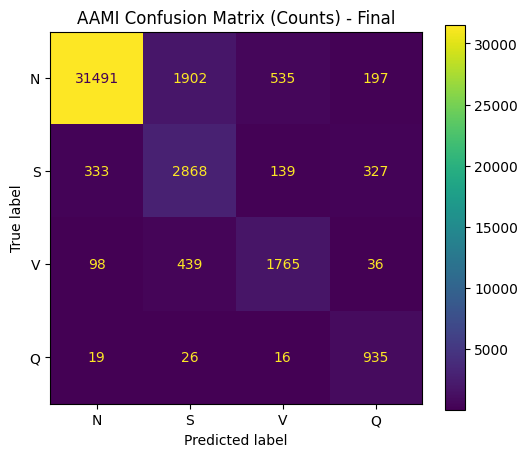

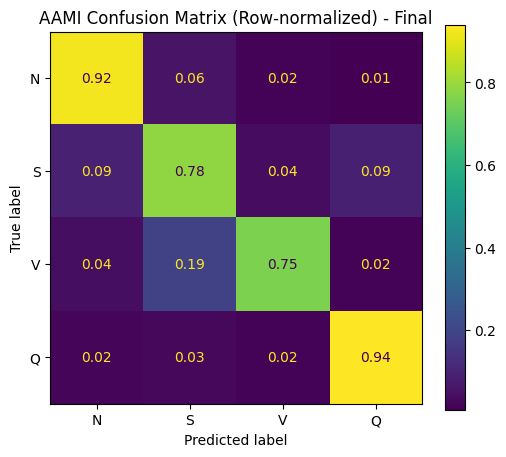

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# FINAL threshold’lı tahminin (sende: ypt)
# Eğer değişken adı farklıysa: ypt = <final preds>
cm = confusion_matrix(y_test, ypt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=AAMI_CLASSES)
fig, ax = plt.subplots(figsize=(6,5))
disp.plot(ax=ax, values_format="d")
plt.title("AAMI Confusion Matrix (Counts) - Final")
plt.show()

cm_norm = cm / cm.sum(axis=1, keepdims=True)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=AAMI_CLASSES)
fig, ax = plt.subplots(figsize=(6,5))
disp2.plot(ax=ax, values_format=".2f")
plt.title("AAMI Confusion Matrix (Row-normalized) - Final")
plt.show()


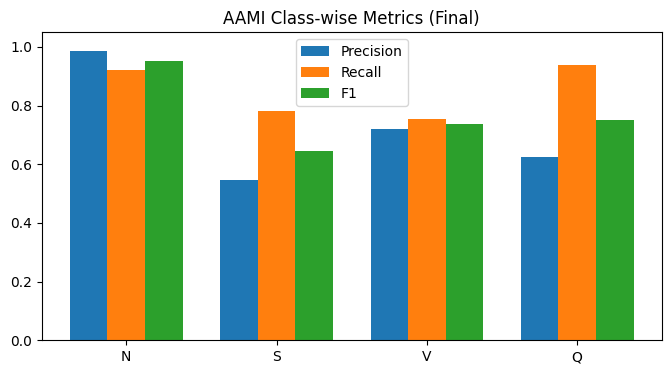

In [17]:
from sklearn.metrics import precision_recall_fscore_support

p, r, f1, sup = precision_recall_fscore_support(y_test, ypt, zero_division=0)

x = np.arange(len(AAMI_CLASSES))
plt.figure(figsize=(8,4))
plt.bar(x-0.25, p, width=0.25, label="Precision")
plt.bar(x,      r, width=0.25, label="Recall")
plt.bar(x+0.25, f1, width=0.25, label="F1")
plt.xticks(x, AAMI_CLASSES)
plt.ylim(0,1.05)
plt.title("AAMI Class-wise Metrics (Final)")
plt.legend()
plt.show()


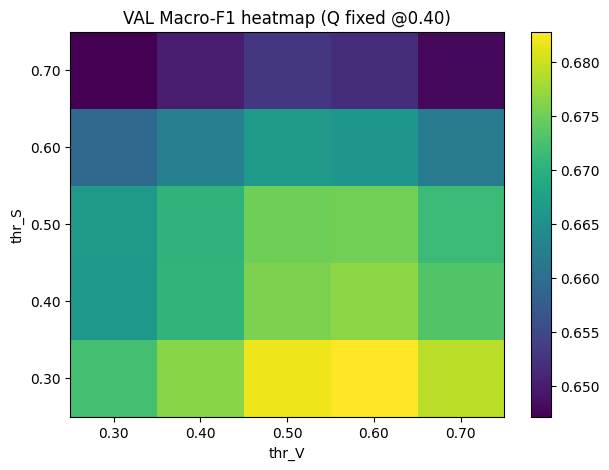

In [18]:
import pandas as pd

# rows listesi sende vardı: (macro, thr_s, thr_v, rS, rV, rQ)
df = pd.DataFrame(rows, columns=["macro","thr_s","thr_v","recS","recV","recQ"])

pivot = df.pivot(index="thr_s", columns="thr_v", values="macro")

plt.figure(figsize=(7,5))
plt.imshow(pivot.values, aspect="auto", origin="lower")
plt.xticks(range(len(pivot.columns)), [f"{c:.2f}" for c in pivot.columns])
plt.yticks(range(len(pivot.index)),   [f"{i:.2f}" for i in pivot.index])
plt.xlabel("thr_V")
plt.ylabel("thr_S")
plt.title("VAL Macro-F1 heatmap (Q fixed @0.40)")
plt.colorbar()
plt.show()


In [19]:
from sklearn.metrics import f1_score

# Baseline (argmax) ile Final (threshold) Macro-F1 karşılaştır
y_base = np.argmax(proba_test, axis=1)
macro_base = f1_score(y_test, y_base, average="macro", zero_division=0)
macro_final = f1_score(y_test, ypt, average="macro", zero_division=0)

print("Macro-F1 baseline (argmax):", macro_base)
print("Macro-F1 final (threshold):", macro_final)
print("Delta:", macro_final - macro_base)


Macro-F1 baseline (argmax): 0.7388342154806249
Macro-F1 final (threshold): 0.771215559239915
Delta: 0.03238134375929014
